In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#import seaborn as sn
import math
from sklearn.preprocessing import OneHotEncoder

In [2]:
def get_data(filename):
    """Get data from filename.

    Args:
        filename (string): name of the file.

    Returns:
        pd.DataFrame: dataframe cointaining data.
    """    
    df = pd.read_csv(filename, names = ['all'])
    df['all'] = df['all'].str.strip()
    df['all1']  = df['all'].apply(lambda x: np.array(x.split(' ')))
    df[['target','attr1','attr2','attr3','attr4','attr5','attr6','id']] = pd.DataFrame(df.all1.tolist(), index= df.index)
    return df.drop(columns=['all','all1'])

In [3]:
df = get_data('/Users/HP/Desktop/UNI/LM_1/MachineLearning/ML_prj/data/MONK/monks-1.train')
df_test = get_data('/Users/HP/Desktop/UNI/LM_1/MachineLearning/ML_prj/data/MONK/monks-1.test')

In [4]:
#df = get_data(r"\Users\s512fj-ej021t\OneDrive\Desktop\ML\monks-1.train")
#df_test = get_data(r"\Users\s512fj-ej021t\OneDrive\Desktop\ML\monks-1.test")

In [5]:
X_train, y_train = df.drop(columns=['target','id']).to_numpy().T, df['target'].apply(lambda x: int(x)).to_numpy().T
X_test, y_test = df_test.drop(columns=['target','id']).to_numpy().T, df_test['target'].apply(lambda x: int(x)).to_numpy().T

In [6]:
def onehot_encoding(x):
    """_summary_

    Args:
        x (_type_): _description_

    Returns:
        _type_: _description_
    """    
    X = []
    for row in x:
        unique = np.unique(row)
        for i in unique:
            X.append((row == i).astype(int))

    return np.array(X)

X_train = onehot_encoding(X_train)

In [7]:
#linear activation function 
def linear(x):
    """Linear function

    Args:
        x (_type_): _description_

    Returns:
        _type_: _description_
    """    
    return x

def d_linear(x):
    """_summary_

    Args:
        x (_type_): _description_

    Returns:
        _type_: _description_
    """    
    return 1

#sigmoid activation function
def sigmoid(x):
    """_summary_

    Args:
        x (_type_): _description_

    Returns:
        _type_: _description_
    """    
    return 1/(1+np.exp(-x))

def d_sigmoid(x):
    """_summary_

    Args:
        x (_type_): _description_

    Returns:
        _type_: _description_
    """    
    f =sigmoid(x)
    return f * (1-f)

#ReLu activation function
def relu(x):
    if x > 0: return x
    else: return 0

def d_relu(x):
    if x > 0: return 1
    else: return 0
    

#hyperbolic tangent activation function
def TanH(x):
    return np.tanh(x)

def d_TanH(x):
    return 1 - math.pow(np.tanh(x), 2) 

#Dictionary for the activation functions
act_func = {
    'lin': linear,
    'sigm': sigmoid,
    'relu': relu,
    'tanh': TanH
}

#A second dictionary for their derivatives
d_act_func = {
    'lin': d_linear,
    'sigm': d_sigmoid,
    'relu': d_relu,
    'tanh': d_TanH
}

def d_MSE(layer, target):
    return 2*(layer - target)/target.shape[1]

def MSE(layer, target):
    return (layer - target)**2/target.shape[1]

def binary_crossentropy(layer, target):
    return - (target * np.log(layer) + (1 - target) * np.log(1 - layer))/target.shape[1]

def d_binary_crossentropy(layer, target):
    return (layer - target)/(layer*(1-layer)*target.shape[1])

def accuracy(y_pred, y_true):
    y_pred = y_pred[0]
    y_true = y_true[0]
    
    y_tmp = (np.array(y_pred) > 0.5).astype(int)
    correct = 0
    for i in range(len(y_tmp)):
        if y_tmp[i] == y_true[i]: correct += 1
    
    return correct / float(len(y_tmp)) * 100.0
    

class Layer:

    def __init__(self, prev_layer, dim_layer, act_function):
  
        self.prev_layer = prev_layer
        self.init_params(dim_layer, act_function) #self.init_params(dim_layer, act_function, input)

    def init_params(self, dim_layer, act_function):
        #self.dim_batch = self.prev_layer.dim_batch
        self.dim_layer = dim_layer
        self.W = np.random.uniform(-0.5, 0.5, (dim_layer, self.prev_layer.dim_layer))    #inizializzo la matrice dei pesi
        self.b = np.random.uniform(-0.5, 0.5, (dim_layer, 1))      #inizializzo il vettore dei bias
        self.layer = None #np.empty((dim_layer, self.dim_batch))
        self.z = None
        self.target = None
        self.act_function = np.vectorize(act_func[act_function])
        self.d_act_function = np.vectorize(d_act_func[act_function])
        

    def forward(self, mode = 'train'):
        if mode == 'train':
            self.z = self.W.dot(self.prev_layer.forward()) + self.b
            self.layer = self.act_function(self.z)

            return self.layer
        elif mode == 'predict':
            return self.act_function(self.W.dot(self.prev_layer.forward(mode = 'predict')) + self.b)
        
    
    def backward(self, next_delta = None, next_weights = None, lossfunc = None, last = False):
        
        if last == True:

            delta = self.d_act_function(self.z) * lossfunc(self.layer,self.target)

            self.d_W = delta.dot(self.prev_layer.backward(delta,self.W).T)
            self.d_b = delta.sum(axis=1).reshape((delta.shape[0],1))
            return self.layer 
           
        else:

            delta = self.d_act_function(self.z) * next_weights.T.dot(next_delta)

            self.d_W = delta.dot(self.prev_layer.backward(delta,self.W).T)
            self.d_b = delta.sum(axis=1).reshape((delta.shape[0],1))
            return self.layer

    def update_weights(self, eta, lam):

        self.W = self.W - eta * self.d_W - lam * self.W
        self.prev_layer.update_weights(eta, lam)

    def err(self):
        return np.sqrt((self.layer[0]-self.target[0])**2+(self.layer[1]-self.target[1])**2+(self.layer[2]-self.target[2])**2).mean()
    
    def rel_err(self):
        return np.sqrt((self.layer[0]-self.target[0])**2/self.target[0]**2+(self.layer[1]-self.target[1])**2/self.target[1]**2+(self.layer[2]-self.target[2])**2/self.target[2]**2).mean()

    def err_i(self,i):
        return np.sqrt((self.layer[i]-self.target[i])**2).mean()
    
    def rel_err_i(self,i):
        return (np.sqrt((self.layer[i]-self.target[i])**2)/self.target[i]).mean()
    
class Input(Layer):

    def __init__(self, input_dim):

        Layer.__init__(self, None, input_dim, 'lin')

    def init_params(self, dim_layer, act_function):
        self.layer = None

        self.dim_layer = dim_layer

    def forward(self, mode = 'train'):

        return self.layer
    
    def backward(self, next_delta = None, next_weights = None):
        return self.layer
    
    def update_weights(self, eta, lam):
        return self.layer
    
    def prova(self):
        return self.dim_layer
        



In [8]:
lossfunc = {'MSE':(MSE,d_MSE),
            'binary_crossentropy':(binary_crossentropy,d_binary_crossentropy)}

In [9]:
class NeuralNetwork:

    def __init__(self, input_layer, output_layer, loss, metrics = []):
        self.input_layer = input_layer
        self.output_layer = output_layer
        self.lossfunc = lossfunc[loss][0]
        self.d_lossfunc = lossfunc[loss][1]
        self.metrics = metrics

    def predict(self,input):
        self.input_layer.layer = input
        return self.output_layer.forward(mode = 'predict')
    
    def update_history_batch(self, history, y_pred, y_true, train_or_val):
        
        history[f'{train_or_val}_loss_var'].append(np.mean((self.lossfunc(y_pred, y_true))))
        for m in self.metrics:
            history[f'{train_or_val}_{m.__name__}_var'].append(np.mean(m(y_pred, y_true)))

    def update_history_epoch(self, history):
        
        history[f'train_loss'].append(np.mean(history[f'train_loss_var']))
        history[f'val_loss'].append(np.mean(history[f'val_loss_var']))
        for m in self.metrics:
            history[f'train_{m.__name__}'].append(np.mean(history[f'train_{m.__name__}_var']))
            history[f'val_{m.__name__}'].append(np.mean(history[f'val_{m.__name__}_var']))
            history[f'train_{m.__name__}_var'] = []
            history[f'val_{m.__name__}_var'] = []

    def print_epoch(self, j, history, eta):

        print(f'Epoch {j}: ', end='')
        print(f'train_loss: {history["train_loss"][-1]:.3e}, ', end = '')
        print(f'val_loss: {history["val_loss"][-1]:.3e}; ', end = '')
        for m in self.metrics:
            print(f'train_{m.__name__}: {history[f"train_{m.__name__}"][-1]:.3e}, ', end = '')
            print(f'val_{m.__name__}: {history[f"val_{m.__name__}"][-1]:.3e}  ', end = '')
        print(f'lr : {eta}')

    def clear_history(self, history):
    
        del history['train_loss_var']
        del history['val_loss_var']
        for m in self.metrics:
            del history[f'train_{m.__name__}_var']
            del history[f'val_{m.__name__}_var']
        return history

    def check_early_stopping(self, history, early_stopping):

        if (history[early_stopping['monitor']][-1] <= history[early_stopping['monitor']][-2]):
            early_stopping['index'] +=1 # !!! Adesso c'è <= per utilizzare la accuracy
        
        else:
            early_stopping['index'] = 0

        if early_stopping['index'] == early_stopping['patience']: 
            print('Early stopped')
            history = self.clear_history
            return 1,history
        return 0,history
    
    def check_reduce_eta(self, history, reduce_eta, eta):
        if (history[reduce_eta['monitor']][-1] <= history[reduce_eta['monitor']][-2]):
            reduce_eta['index'] +=1

        else:
            reduce_eta['index'] = 0

        if reduce_eta['index'] == reduce_eta['patience']: 
            eta = eta*reduce_eta['factor']
            reduce_eta['index'] = 0
            print(f'Reduced learning rate, new eta = {eta}')
        return eta

    def init_history(self):

        history = {'train_loss': [],
                    'train_loss_var': [],
                    'val_loss': [],
                    'val_loss_var': []}
        
        for m in self.metrics:
            history[f'train_{m.__name__}'] = []
            history[f'train_{m.__name__}_var'] = []
            history[f'val_{m.__name__}'] = []
            history[f'val_{m.__name__}_var'] = []

        return history

    def train(self, input, target, epochs, eta, lam, n_batch, validation_split = 0.5, validation_data = None, early_stopping = None, reduce_eta = None, verbose = 1): #callbacks
        
        # Checking conflicts between parameters:
        if n_batch > input.shape[1]:
            raise ValueError("n_batch can't be bigger than training set lenght.")
        
        # Inserire check su dimensioni array, ecc.

        #Initialize parameters:
        if early_stopping is not None:
            early_stopping['index'] = 0

        if reduce_eta is not None:
            reduce_eta['index'] = 0

        # Initialize history.
        history = self.init_history()
        
        if validation_data is not None:

            val_input = validation_data[0]
            val_target = validation_data[1]

            train_input = input
            train_target = target

        else:

            dim_input = input.shape[1] # number of columns in input

            validation_div = np.floor((1-validation_split)*dim_input).astype(int) # number of elements in validation set

            if n_batch > np.floor(validation_split*dim_input).astype(int):
                raise ValueError("n_batch can't be bigger than training set lenght.")

            index = np.arange(dim_input) # array of index
            np.random.shuffle(index)
            input = input[:,index]
            target = target[:,index]

            val_input = input[:,validation_div:] # validation input
            val_target = target[:,validation_div:] # validation target

            train_input = input[:,:validation_div] # train input
            train_target = target[:,:validation_div] # train target

        index = np.arange(train_input.shape[1]) # array of index 

        j = 0

        while j < epochs:

            np.random.shuffle(index)
            input_new = train_input[:,index]
            target_new = train_target[:,index]

            for k in range(input_new.shape[1]//n_batch):

                y_pred_val = self.predict(val_input)

                self.update_history_batch(history, y_pred_val, val_target, 'val')

                if k == input_new.shape[1]//n_batch -1:
                    self.input_layer.layer = input_new[:,k*n_batch:]
                    self.output_layer.target = target_new[:,k*n_batch:]
                else:
                    self.input_layer.layer = input_new[:,k*n_batch:(k+1)*n_batch]
                    self.output_layer.target = target_new[:,k*n_batch:(k+1)*n_batch]

                y_pred_train = self.output_layer.forward()

                self.update_history_batch(history, y_pred_train, self.output_layer.target, 'train')
                
                self.output_layer.backward(lossfunc = self.d_lossfunc, last = True)
                self.output_layer.update_weights(eta, lam)
                
            self.update_history_epoch(history)

            if verbose == 1:
                self.print_epoch(j, history, eta)

            if j > 1:
                
                if early_stopping is not None:
                    check, history = self.check_early_stopping(history, early_stopping)
                    if check == 1: return history

                if reduce_eta is not None:
                    eta = self.check_reduce_eta(history, reduce_eta, eta)

            j += 1
        
        return self.clear_history(history)

In [10]:
early_stopping = {'patience' : 800,
                  'monitor' : 'val_accuracy'}

reduce_eta = {'patience' : 500,
              'monitor' : 'val_accuracy',
              'factor' : 0.25}

In [11]:
input_layer = Input(17)
hidden_layer = Layer(input_layer, 15, 'tanh')
output_layer = Layer(hidden_layer, 1, 'sigm')

model = NeuralNetwork(input_layer, output_layer, loss = 'binary_crossentropy', metrics = [accuracy])
history = model.train(X_train, y_train.reshape((1,124)), epochs = 10000,
                                    eta = 0.025, lam = 0.0, n_batch = 31,
                                    validation_split = 0.5,
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 2.336e-02, val_loss: 1.205e-02; train_accuracy: 4.516e+01, val_accuracy: 4.839e+01  lr : 0.025
Epoch 1: train_loss: 2.332e-02, val_loss: 1.203e-02; train_accuracy: 4.516e+01, val_accuracy: 4.839e+01  lr : 0.025
Epoch 2: train_loss: 2.329e-02, val_loss: 1.202e-02; train_accuracy: 4.516e+01, val_accuracy: 4.839e+01  lr : 0.025
Epoch 3: train_loss: 2.326e-02, val_loss: 1.200e-02; train_accuracy: 4.355e+01, val_accuracy: 4.839e+01  lr : 0.025
Epoch 4: train_loss: 2.322e-02, val_loss: 1.199e-02; train_accuracy: 4.194e+01, val_accuracy: 4.839e+01  lr : 0.025
Epoch 5: train_loss: 2.319e-02, val_loss: 1.197e-02; train_accuracy: 4.355e+01, val_accuracy: 4.839e+01  lr : 0.025
Epoch 6: train_loss: 2.316e-02, val_loss: 1.196e-02; train_accuracy: 4.355e+01, val_accuracy: 4.839e+01  lr : 0.025
Epoch 7: train_loss: 2.313e-02, val_loss: 1.195e-02; train_accuracy: 4.355e+01, val_accuracy: 4.839e+01  lr : 0.025
Epoch 8: train_loss: 2.310e-02, val_loss: 1.193e-02; train_accuracy: 4.3

Epoch 19: train_loss: 2.278e-02, val_loss: 1.180e-02; train_accuracy: 4.516e+01, val_accuracy: 4.839e+01  lr : 0.025
Epoch 20: train_loss: 2.275e-02, val_loss: 1.178e-02; train_accuracy: 4.516e+01, val_accuracy: 4.839e+01  lr : 0.025
Epoch 21: train_loss: 2.272e-02, val_loss: 1.177e-02; train_accuracy: 4.516e+01, val_accuracy: 4.839e+01  lr : 0.025
Epoch 22: train_loss: 2.270e-02, val_loss: 1.176e-02; train_accuracy: 4.677e+01, val_accuracy: 4.839e+01  lr : 0.025
Epoch 23: train_loss: 2.267e-02, val_loss: 1.175e-02; train_accuracy: 4.677e+01, val_accuracy: 4.839e+01  lr : 0.025
Epoch 24: train_loss: 2.265e-02, val_loss: 1.174e-02; train_accuracy: 4.677e+01, val_accuracy: 5.000e+01  lr : 0.025
Epoch 25: train_loss: 2.262e-02, val_loss: 1.173e-02; train_accuracy: 4.677e+01, val_accuracy: 5.081e+01  lr : 0.025
Epoch 26: train_loss: 2.259e-02, val_loss: 1.172e-02; train_accuracy: 4.839e+01, val_accuracy: 5.081e+01  lr : 0.025
Epoch 27: train_loss: 2.257e-02, val_loss: 1.171e-02; train_accu

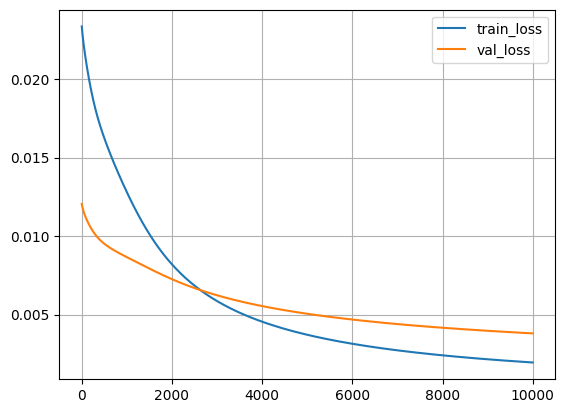

In [12]:
plt.plot(history['train_loss'],label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.grid()
plt.legend()

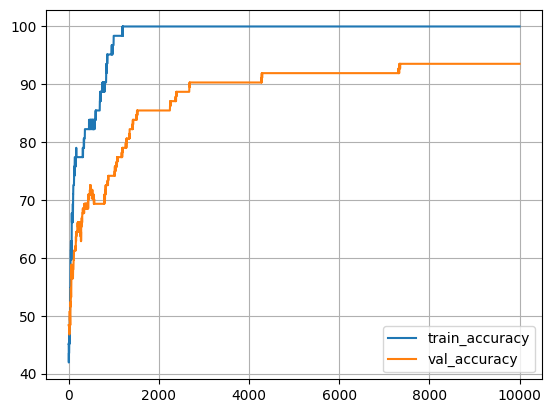

In [13]:
plt.plot(history['train_accuracy'],label='train_accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.grid()
plt.legend()

In [14]:
X_test = onehot_encoding(X_test)

In [15]:
y_pred = model.predict(X_test)

In [16]:
y_pred = (y_pred>0.5).astype(int)

In [17]:
y_pred == y_test

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

In [18]:
print(output_layer.layer)
print(output_layer.target)

[[9.99981458e-01 5.57480150e-04 4.44193085e-04 6.38012757e-03
  2.80911507e-03 9.86086692e-01 8.79762435e-04 2.29467545e-03
  1.43621703e-03 9.99946145e-01 9.88516874e-01 4.58489806e-03
  1.46771271e-04 5.89193044e-03 9.17226279e-03 9.99975045e-01
  9.88230637e-01 9.99849082e-01 9.94189795e-01 2.22829365e-03
  9.95941128e-01 9.99970308e-01 3.23721778e-04 5.00887998e-03
  9.99900668e-01 9.89326410e-01 9.02529744e-04 2.42339955e-04
  9.99422735e-01 9.95090976e-01 9.94692577e-01]]
[[1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1]]


In [43]:
def cross_validation(input, target, folds, metrics):
    dim_input = input.shape[1]
    input_index = np.arange(dim_input)
    np.random.shuffle(input_index)
    subset_index = []
    
    for i in range(folds-1):
        subset_index.append(input_index[i*np.round(dim_input / folds).astype(int): (i+1)*np.round(dim_input / folds).astype(int)])
    subset_index.append(input_index[(i+1)*np.round(dim_input / folds).astype(int):])

   
    history_cv = {'train_loss': [],
                  #'train_loss_var': [],
                  'val_loss': []
                  #'val_loss_var': []
                  }
    
    for m in metrics:
        history_cv[f'train_{m.__name__}'] = []
        #history_cv[f'train_{m.__name__}_var'] = []
        history_cv[f'val_{m.__name__}'] = []
        #history_cv[f'val_{m.__name__}_var'] = []

    for val_ind in subset_index:

        train_ind = list(set(input_index) - set(val_ind))

        train_input = input[:,train_ind]
        train_target = target[:,train_ind]
        val_input = input[:,val_ind]
        val_target = target[:,val_ind]

        input_layer = Input(17)
        hidden_layer = Layer(input_layer, 15, 'tanh')
        output_layer = Layer(hidden_layer, 1, 'sigm')

        model = NeuralNetwork(input_layer, output_layer, loss = 'binary_crossentropy', metrics = metrics)

        history = model.train(train_input, train_target, epochs = 1000,
                                            eta = 0.025, lam = 0.0, n_batch = 31,
                                            validation_data = [val_input, val_target],
                                            early_stopping=None,
                                            reduce_eta=None
                                            )
        
        history_cv['train_loss'].append(history['train_loss'][-1])
        history_cv['val_loss'].append(history['val_loss'][-1])
        for m in metrics:
            history_cv[f'train_{m.__name__}'].append(history[f'train_{m.__name__}'][-1])
            #history_cv[f'train_{m.__name__}_var'] = []
            history_cv[f'val_{m.__name__}'].append(history[f'val_{m.__name__}'][-1])
            #history_cv[f'val_{m.__name__}_var'] = []
    return history_cv
            

In [44]:
history_cv = cross_validation(X_train, y_train.reshape((1,124)), 5, metrics = [accuracy])

Epoch 0: train_loss: 2.490e-02, val_loss: 3.031e-02; train_accuracy: 3.807e+01, val_accuracy: 4.800e+01  lr : 0.025
Epoch 1: train_loss: 2.488e-02, val_loss: 3.023e-02; train_accuracy: 3.790e+01, val_accuracy: 4.800e+01  lr : 0.025
Epoch 2: train_loss: 2.471e-02, val_loss: 3.014e-02; train_accuracy: 3.752e+01, val_accuracy: 4.800e+01  lr : 0.025
Epoch 3: train_loss: 2.462e-02, val_loss: 3.006e-02; train_accuracy: 3.807e+01, val_accuracy: 4.800e+01  lr : 0.025
Epoch 4: train_loss: 2.448e-02, val_loss: 2.999e-02; train_accuracy: 3.894e+01, val_accuracy: 4.800e+01  lr : 0.025
Epoch 5: train_loss: 2.435e-02, val_loss: 2.991e-02; train_accuracy: 3.859e+01, val_accuracy: 4.800e+01  lr : 0.025
Epoch 6: train_loss: 2.424e-02, val_loss: 2.984e-02; train_accuracy: 3.824e+01, val_accuracy: 4.800e+01  lr : 0.025
Epoch 7: train_loss: 2.413e-02, val_loss: 2.977e-02; train_accuracy: 3.807e+01, val_accuracy: 4.800e+01  lr : 0.025
Epoch 8: train_loss: 2.402e-02, val_loss: 2.971e-02; train_accuracy: 3.9

In [45]:
history_cv

{'train_loss': [0.012552668341972049,
  0.010396586255317773,
  0.011096103547852365,
  0.011409659460266891,
  0.010001217376979067],
 'val_loss': [0.02040904528015875,
  0.022722027190527513,
  0.02201512572398896,
  0.019159835393185495,
  0.02068630912781607],
 'train_accuracy': [91.74658529497238,
  96.04766056378959,
  98.0238302818948,
  96.04766056378959,
  100.0],
 'val_accuracy': [76.0, 84.0, 88.0, 84.0, 83.33333333333334]}

In [ ]:
params = {'eta' : [0.01,0.02,0.03],
          'lam' : [0.01,0.02,0.03],
          'dim_hidden': [5,10,15]
}

In [20]:
input = np.random.random((17,232))
dim_input = input.shape[1]
folds = 5
print(dim_input / folds)
print(dim_input % folds)
arr = []
index = np.arange(dim_input)
for i in range(folds-1):
    arr.append(index[i*np.round(dim_input / folds).astype(int): (i+1)*np.round(dim_input / folds).astype(int)])
arr.append(index[(i+1)*np.round(dim_input / folds).astype(int):])

46.4
2


In [26]:
print(set(arr[0]))
print(set(index)-set(arr[0]))
print(input[:,list(set(index)-set(arr[0]))])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45}
{46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221

In [21]:
arr[1].shape

(46,)